In [34]:
import cv2

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="UDBllPiVKHipSlYi7N2u")
project = rf.workspace("atharva-desai-x1nvf").project("rock-analysis")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Dependency ultralytics==8.0.196 is required but found version=8.0.227, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to rock-analysis-1 in yolov8:: 100%|██████████| 612/612 [00:00<00:00, 9521.51it/s]


In [ ]:
import torch

torch.cuda.set_device(0)

In [3]:
from ultralytics import YOLO

model = YOLO("/home/ishan/Projects/Flask/best.pt")

results = model.predict("/home/ishan/Projects/Flask/rock.jpg")


image 1/1 /home/ishan/Projects/Flask/rock.jpg: 640x640 3 rocks, 75.2ms
Speed: 2.6ms preprocess, 75.2ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


In [22]:
results[0].masks.shape

torch.Size([3, 640, 640])

In [16]:
from PIL import Image

for detection in results:
    bgr_array = detection.masks.plot()
    rgb_array = bgr_array[..., ::-1]
    output_image = Image.fromarray(rgb_array)

AttributeError: 'Masks' object has no attribute 'plot'. See valid attributes below.

    A class for storing and manipulating detection masks.

    This class extends BaseTensor and provides functionality for handling segmentation masks,
    including methods for converting between pixel and normalized coordinates.

    Attributes:
        data (torch.Tensor | numpy.ndarray): The raw tensor or array containing mask data.
        orig_shape (tuple): Original image shape in (height, width) format.
        xy (List[numpy.ndarray]): A list of segments in pixel coordinates.
        xyn (List[numpy.ndarray]): A list of normalized segments.

    Methods:
        cpu(): Returns a copy of the Masks object with the mask tensor on CPU memory.
        numpy(): Returns a copy of the Masks object with the mask tensor as a numpy array.
        cuda(): Returns a copy of the Masks object with the mask tensor on GPU memory.
        to(*args, **kwargs): Returns a copy of the Masks object with the mask tensor on specified device and dtype.

    Examples:
        >>> masks_data = torch.rand(1, 160, 160)
        >>> orig_shape = (720, 1280)
        >>> masks = Masks(masks_data, orig_shape)
        >>> pixel_coords = masks.xy
        >>> normalized_coords = masks.xyn
    

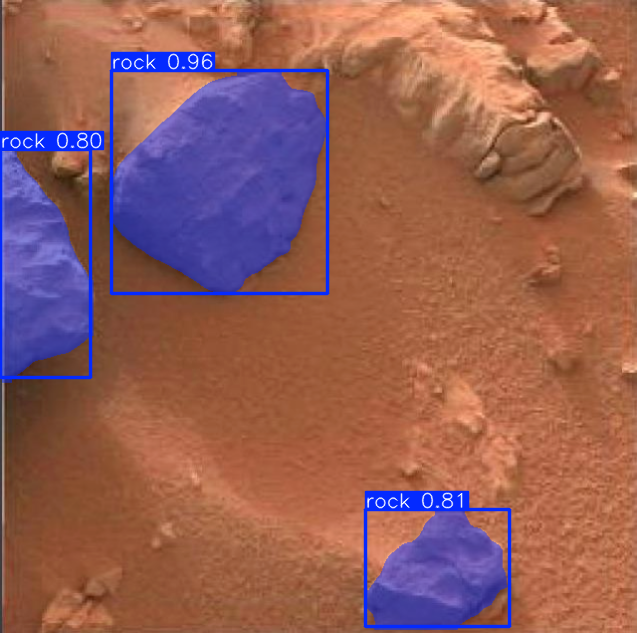

In [5]:
output_image

In [30]:
results[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
orig_shape: (633, 637)
shape: torch.Size([3, 640, 640])
xy: [array([[     236.88,      71.653],
       [     236.88,      74.639],
       [     235.89

In [61]:
orig_img = cv2.imread('rock.jpg')

if(results[0].masks is not None):
    # Convert mask to single channel image
    mask_raw = results[0].masks[0].cpu().data.numpy().transpose(1, 2, 0)
    
    # Convert single channel grayscale to 3 channel image
    mask_3channel = cv2.merge((mask_raw,mask_raw,mask_raw))

    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = results[0].orig_img.shape
    
    # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
    mask = cv2.resize(mask_3channel, (w2, h2))

    # Convert BGR to HSV
    hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

    # Define range of brightness in HSV
    lower_black = np.array([0,0,0])
    upper_black = np.array([0,0,1])

    # Create a mask. Threshold the HSV image to get everything black
    mask = cv2.inRange(mask, lower_black, upper_black)

    # Invert the mask to get everything but black
    mask = cv2.bitwise_not(mask)

    # Apply the mask to the original image
    masked = cv2.bitwise_and(results[0].orig_img, results[0].orig_img, mask=mask)

In [65]:
if results[0].masks is not None:
    # Convert mask to single channel image
    mask_raw = results[0].masks[0].cpu().data.numpy().transpose(1, 2, 0)
    
    # Convert single channel grayscale mask to 3 channel mask
    mask_3channel = cv2.merge((mask_raw, mask_raw, mask_raw))

    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = orig_img.shape
    
    # Resize the mask to the same size as the image (if necessary)
    mask = cv2.resize(mask_3channel, (w2, h2))

    # Define the color you want for the mask (e.g., red)
    mask_color = (0, 0, 255)  # BGR format (Red color in this example)

    # Convert the mask to the desired color
    colored_mask = np.zeros_like(orig_img)
    colored_mask[:] = mask_color

    # Create a binary mask for where the mask exists
    binary_mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)  # Binary mask
    
    # Convert binary mask to 3 channel format
    binary_mask_3channel = cv2.merge((binary_mask, binary_mask, binary_mask))
    
    # Apply the colored mask to the original image
    colored_mask = cv2.bitwise_and(colored_mask, colored_mask, mask=binary_mask)
    
    # Overlay the colored mask on the original image
    masked_image = cv2.addWeighted(orig_img, 1.0, colored_mask, 0.5, 0)

    # Save or display the result
    cv2.imwrite('/home/ishan/Projects/Flask/rock_with_colored_mask.jpg', masked_image)
    plt.imshow('Masked Image', masked_image)

error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


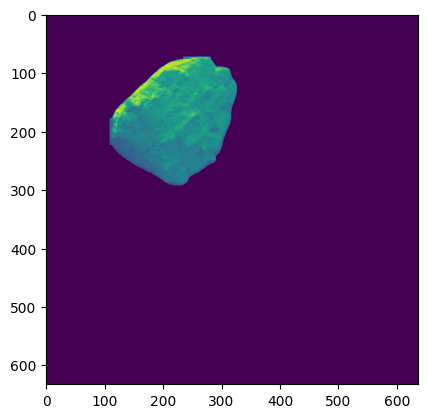

In [64]:
import matplotlib.pyplot as plt

plt.imshow(masked)

In [63]:
base_image = cv2.imread('rock.jpg')
masked = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)

alpha = 0.5  # Weight of the base image
beta = 1  # Weight of the overlay image
blended_image = cv2.addWeighted(base_image, alpha, masked, beta, 0)

blended_image = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)


error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


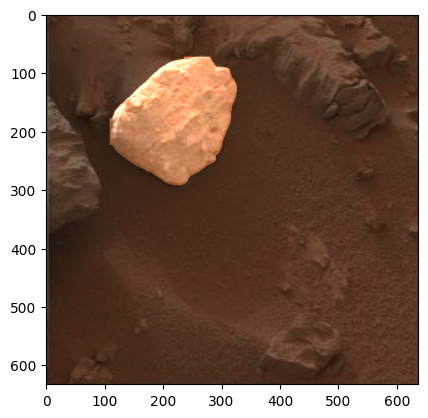

In [57]:
plt.imshow(blended_image)

In [51]:
from ultralytics import YOLO
import cv2
import numpy as np

# Load the model
model = YOLO("/home/ishan/Projects/Flask/best.pt")

# Perform prediction on the image
results = model.predict("/home/ishan/Projects/Flask/rock.jpg")

# Load the original image
image = cv2.imread("/home/ishan/Projects/Flask/rock.jpg")

# Iterate through the results and draw bounding boxes
for result in results:
    boxes = result.boxes
    for box in boxes:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Convert to integer coordinates
        
        # Draw the bounding box on the original image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green color, thickness=2
        
        # Optionally, display the label and score
        label = int(box.cls[0].item())  # Class label (if available)
        score = box.conf[0].item()  # Confidence score (if available)
        text = f"{label} {score:.2f}"
        
        # Define font scale and thickness
        font_scale = 0.75
        thickness = 2
        color = (0, 255, 0)  # Green color
        
        # Calculate text size for better positioning
        text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        text_width, text_height = text_size
        
        # Draw the text background for better readability
        cv2.rectangle(image, (x1, y1 - text_height - 10), (x1 + text_width, y1), (0, 0, 0), -1)  # Black background
        
        # Draw the text on the image
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)
        
# Save or display the image with drawn bounding boxes and text
cv2.imwrite("/home/ishan/Projects/Flask/rock_with_bboxes.jpg", image)



image 1/1 /home/ishan/Projects/Flask/rock.jpg: 640x640 3 rocks, 126.4ms
Speed: 3.7ms preprocess, 126.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


True